In [1]:
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()
from fastbook import *

     |████████████████████████████████| 727kB 5.5MB/s 
     |████████████████████████████████| 51kB 4.3MB/s 
     |████████████████████████████████| 194kB 12.0MB/s 
     |████████████████████████████████| 1.2MB 17.6MB/s 
     |████████████████████████████████| 61kB 9.1MB/s 
Mounted at /content/gdrive


# ResNet - Residual Net

Die ResNet-Architektur wurde 2015 von Kaiming He e.a. eingeführt: ["Deep Residual Learning for Image Recognition"](https://arxiv.org/abs/1512.03385).

ResNet stellt heute die Basis für praktisch alle Architekturen aus dem Bereich Computer Vision dar.

## ImageNette
Da wir beim MNIST Datenset schon beinahe eine Genauigkeit von 100% erreicht haben, benötigen wir ein komplexeres Datenset.

In [2]:
def get_data(url, presize, resize):
    path = untar_data(url)
    return DataBlock(
        blocks=(ImageBlock, CategoryBlock), get_items=get_image_files, 
        splitter=GrandparentSplitter(valid_name='val'),
        get_y=parent_label, item_tfms=Resize(presize),
        batch_tfms=[*aug_transforms(min_scale=0.5, size=resize),
                    Normalize.from_stats(*imagenet_stats)],
    ).dataloaders(path, bs=128)

In [3]:
dls = get_data(URLs.IMAGENETTE_160, 160, 128)

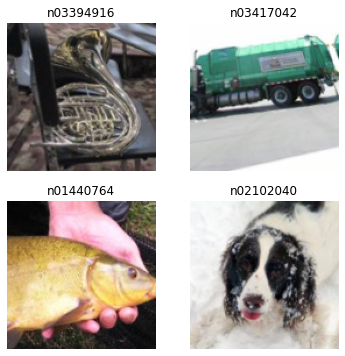

In [4]:
dls.show_batch(max_n=4)

Unsere Bilder aus dem MNIST Datenset hatten eine Auflösung von 28x28 Pixel. Nun verwenden wir Bilder mit 128x128 Pixel. Wir möchten jedoch auch Bilder in der Auflösung von ImageNet (224x224) verwenden können.

Um einen einzelnen Vektor, der alle Aktivierungen für die Bilder aus dem Datenset enthält, aus dem MNIST CNN zu erhalten, haben wir Folgendes gemacht:

*Wir haben sichergestellt, dass ausreichend stride-2 Convolutions in der Netzwerkarchitektur vorhanden sind, sodass der letzte Layer eine Dimension von genau 1 hat.*

*Danach haben wir einen `flatten`-Layer eingefügt, um die Dimensionen auf eine einzige zu reduzieren und so eine Matrix an Aktivierungen für jeden Mini-Batch zu erhalten*

**Warum können wir dieses Vorgehen nun nicht so direkt anwenden?**

  * Wir benötigen sehr viele stride-2 Layer, um schlußendlich auf die Dimension von 1x1 Pixel zu kommen.
  * Unser Modell würde nicht mit einer beliebigen Pixelgröße arbeiten können.

**Lösungsansätze:**

  * Einfach den letzten Layer in einen einzelnen Vektor konvertieren. Das war das Standardverhalten bis etwa 2013. Auch die Gewinner-Architektur VGG setzte diesen Ansatz ein.
    * Dieser Ansatz setzt voraus, dass die Größe der Bilder zur Trainingszeit gleich ist der Größe im Echtbetrieb.
    * Großer Speicherbedarf durch das "Flattening" und damit verbundener großer `weight`-matrices.
    * **Fully Convolutional Networks**: Errechnen des Mittelwerts der Aktivierungen über die Convolution.   


In [5]:
def avg_pool(x): return x.mean((2,3))

  * - PyTorch enthält dafür die Funktion `nn.AdaptiveAvgPool2d`
    - Ein *fully convolution network* beinhaltet eine bestimmte Anzahl an convolutional Layern, am Ende einen adaptive average pooling layer und einen flatten layer, um die Dimensionen am Ende zu reduzieren.

In [6]:
def block(ni, nf): return ConvLayer(ni, nf, stride=2)
def get_model():
    return nn.Sequential(
        block(3, 16),
        block(16, 32),
        block(32, 64),
        block(64, 128),
        block(128, 256),
        nn.AdaptiveAvgPool2d(1),
        Flatten(),
        nn.Linear(256, dls.c))

In [7]:
def get_learner(m):
    return Learner(dls, m, loss_func=nn.CrossEntropyLoss(), metrics=accuracy
                  ).to_fp16()

learn = get_learner(get_model())

SuggestedLRs(lr_min=0.010000000149011612, lr_steep=0.010964781977236271)

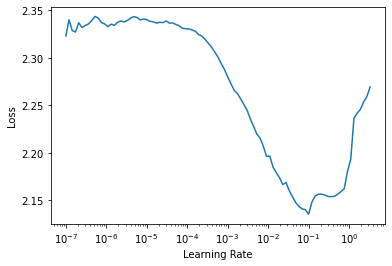

In [8]:
learn.lr_find()

In [9]:
learn.fit_one_cycle(5, 3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.868991,1.925463,0.344968,00:25
1,1.527923,1.353461,0.553376,00:25
2,1.294551,1.271174,0.600510,00:25
3,1.137657,1.132905,0.637707,00:25
4,1.039191,1.078300,0.656306,00:25


## Moderne CNN-Architektur mit ResNet

In [10]:
class ResBlock(Module):
    def __init__(self, ni, nf):
        self.convs = nn.Sequential(
            ConvLayer(ni,nf),
            ConvLayer(nf,nf, norm_type=NormType.BatchZero))
        
    def forward(self, x): return x + self.convs(x)

Diese Implementierung weist jedoch zwei markante Schwachstellen auf:

* Es kann nur ein `stride` von 1 verwendet werden
* Es muss `ni == nf` gelten

In [11]:
def _conv_block(ni,nf,stride):
    return nn.Sequential(
        ConvLayer(ni, nf, stride=stride),
        ConvLayer(nf, nf, act_cls=None, norm_type=NormType.BatchZero))

In [12]:
class ResBlock(Module):
    def __init__(self, ni, nf, stride=1):
        self.convs = _conv_block(ni,nf,stride)
        self.idconv = noop if ni==nf else ConvLayer(ni, nf, 1, act_cls=None)
        self.pool = noop if stride==1 else nn.AvgPool2d(2, ceil_mode=True)

    def forward(self, x):
        return F.relu(self.convs(x) + self.idconv(self.pool(x)))

In [13]:
def block(ni,nf): return ResBlock(ni, nf, stride=2)
learn = get_learner(get_model())

In [14]:
learn.fit_one_cycle(5, 3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.946351,1.899665,0.333248,00:26
1,1.663120,1.500727,0.495032,00:26
2,1.389520,1.329815,0.591847,00:26
3,1.161556,1.058795,0.668790,00:27
4,1.014939,1.032462,0.668535,00:26


In [15]:
def block(ni, nf):
    return nn.Sequential(ResBlock(ni, nf, stride=2), ResBlock(nf, nf))

In [16]:
learn = get_learner(get_model())
learn.fit_one_cycle(5, 3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.953816,1.862555,0.359236,00:27
1,1.615697,1.618666,0.459363,00:27
2,1.323612,1.215589,0.605350,00:27
3,1.099208,0.988323,0.683312,00:27
4,0.961122,0.950794,0.692994,00:27


### Verbesserungen für unsere ResNet Architektur

In [18]:
def _resnet_stem(*sizes):
    return [
        ConvLayer(sizes[i], sizes[i+1], 3, stride = 2 if i==0 else 1)
            for i in range(len(sizes)-1)
    ] + [nn.MaxPool2d(kernel_size=3, stride=2, padding=1)]

In [19]:
_resnet_stem(3,32,32,64)

[ConvLayer(
   (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
   (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (2): ReLU()
 ), ConvLayer(
   (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
   (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (2): ReLU()
 ), ConvLayer(
   (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
   (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (2): ReLU()
 ), MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)]

In [20]:
class ResNet(nn.Sequential):
    def __init__(self, n_out, layers, expansion=1):
        stem = _resnet_stem(3,32,32,64)
        self.block_szs = [64, 64, 128, 256, 512]
        for i in range(1,5): self.block_szs[i] *= expansion
        blocks = [self._make_layer(*o) for o in enumerate(layers)]
        super().__init__(*stem, *blocks,
                         nn.AdaptiveAvgPool2d(1), Flatten(),
                         nn.Linear(self.block_szs[-1], n_out))
    
    def _make_layer(self, idx, n_layers):
        stride = 1 if idx==0 else 2
        ch_in,ch_out = self.block_szs[idx:idx+2]
        return nn.Sequential(*[
            ResBlock(ch_in if i==0 else ch_out, ch_out, stride if i==0 else 1)
            for i in range(n_layers)
        ])

In [21]:
#ResNet-18
rn = ResNet(dls.c, [2,2,2,2])

In [22]:
learn = get_learner(rn)
learn.fit_one_cycle(5, 3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.635701,2.130384,0.409682,00:28
1,1.309332,1.392882,0.574522,00:28
2,1.062591,0.984514,0.673885,00:27
3,0.867334,0.831463,0.736815,00:28
4,0.747209,0.789116,0.746497,00:28


### Bottleneck Design

In [23]:
def _conv_block(ni,nf,stride):
    return nn.Sequential(
        ConvLayer(ni, nf//4, 1),
        ConvLayer(nf//4, nf//4, stride=stride), 
        ConvLayer(nf//4, nf, 1, act_cls=None, norm_type=NormType.BatchZero))

In [24]:
dls = get_data(URLs.IMAGENETTE_320, presize=320, resize=224)

In [25]:
rn = ResNet(dls.c, [3,4,6,3], 4)

In [26]:
learn = get_learner(rn)
learn.fit_one_cycle(20, 3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.597881,1.492765,0.521529,01:16
1,1.361169,2.370851,0.474395,01:16
2,1.213553,1.509615,0.565605,01:14
3,1.138530,2.479876,0.455541,01:15
4,1.039335,1.070725,0.668790,01:14
5,0.951522,1.273080,0.571465,01:14
6,0.848031,4.406971,0.388025,01:14
7,0.766557,0.973783,0.692994,01:13
8,0.708286,0.881187,0.718726,01:13
9,0.644599,0.928297,0.704713,01:13
